# Détection des émotions avec Keras & FER2013

- Dans ce notebook, nous développerons un réseau de neurones permettant de détecter les émotions.
- Nous utiliserons la librairie Keras et le dataset FER2013.

#### *Notebook réalisé dans Google Colab

## Traitement des données

### Importation des librairies

In [1]:
import numpy as np
from numpy import expand_dims
from keras.utils import img_to_array
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")
import tensorflow as tf
import itertools
import keras
import cv2

from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.applications import VGG16

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

### Importation du dataset FER2013

In [2]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [3]:
import pandas as pd

data= pd.read_csv('/content/drive/MyDrive/briefs/emotion_detector/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Observation de la répartition des émotions dans le dataset via un tableau

In [4]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


On remarque ici que le nombre d'image n'est pas correctement réparti en fonction des émotions, pour que le modèle soit optimal il faudra faire une data augmentation sur différentes émotions, pour que le nombre d'image par émotion soit le même.

### Observation de la répartition du dataset

In [5]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

On remarque que le dataset est déjà partionné en 'train set', 'validation set' & 'test set'.


### Split du dataset en training, validation & test.

In [6]:
data_train = data[data['Usage'] == 'Training']
data_val = data[data['Usage'] == 'PrivateTest']
data_test = data[data['Usage'] == 'PublicTest']
print("train shape: {} \nvalidation shape: {} \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3) 
validation shape: (3589, 3) 
test shape: (3589, 3)


### Affichage graphique de la répartition des émotions dans le dataset

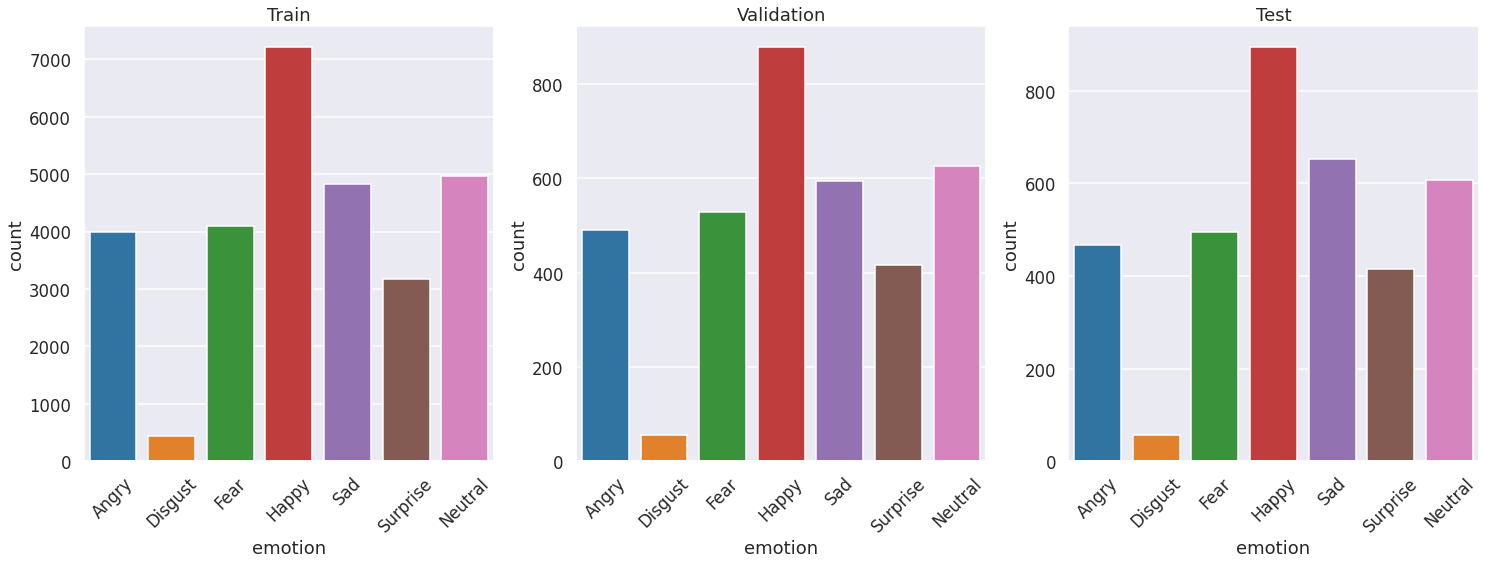

In [7]:
def affichage_datas():
  fig, ax = plt.subplots(1,3, figsize=(25,8))
  #TRAIN
  sns.countplot(x=data_train['emotion'],data=data_train,ax=ax[0])
  ax[0].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_title("Train")
  #VALIDATION
  sns.countplot(x=data_val['emotion'],data=data_val,ax=ax[1])
  ax[1].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_title("Validation")
  #TEST
  sns.countplot(x=data_test['emotion'],data=data_test, ax=ax[2])
  ax[2].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[2].set_title("Test")
  plt.show()
  return

affichage_datas()

Cet affichage nous permet de confirmer que l'émotion 'disgust' est sous représentée comparé aux autres émotions, il est donc important de faire une data augmentation pour la hisser aux mêmes niveaux.

### Data Augmentation de l'émotion 'disgust' sur le train set.

In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    horizontal_flip=True,
    brightness_range=[0.2,1.0]
)


def augmentation_data(data,emotion,multiplicateur):
    for index, row in data.iterrows():
        
        # code pour transformer chaque ligne en image
        if row[0]==emotion:
            to_array = [int(i) for i in row[1].split(" ")]
            to_image = np.reshape(to_array,(48,48))
        
        # effectuer une transformation
            image_to_array = img_to_array(to_image)
            samples = expand_dims(image_to_array, 0)
            it = datagen.flow(samples, batch_size=1)
            for i in range(multiplicateur):
                batch = it.next()
                new_image = batch[0].astype('uint8')

            # applatir la nouvelle image 
                new_image = new_image.ravel()
            
            # la transformer en string
                temp=""
                for i in range(0,len(new_image)):
                    temp += str(new_image[i])+" "
                
            # concatener le resultat au dataframe
                df_temp= pd.DataFrame({'emotion': row[0], 'pixels': temp},index = [0])
                data = pd.concat([data, df_temp],ignore_index = True)
    return data
     

In [9]:
data_train = augmentation_data(data_train,1,6)

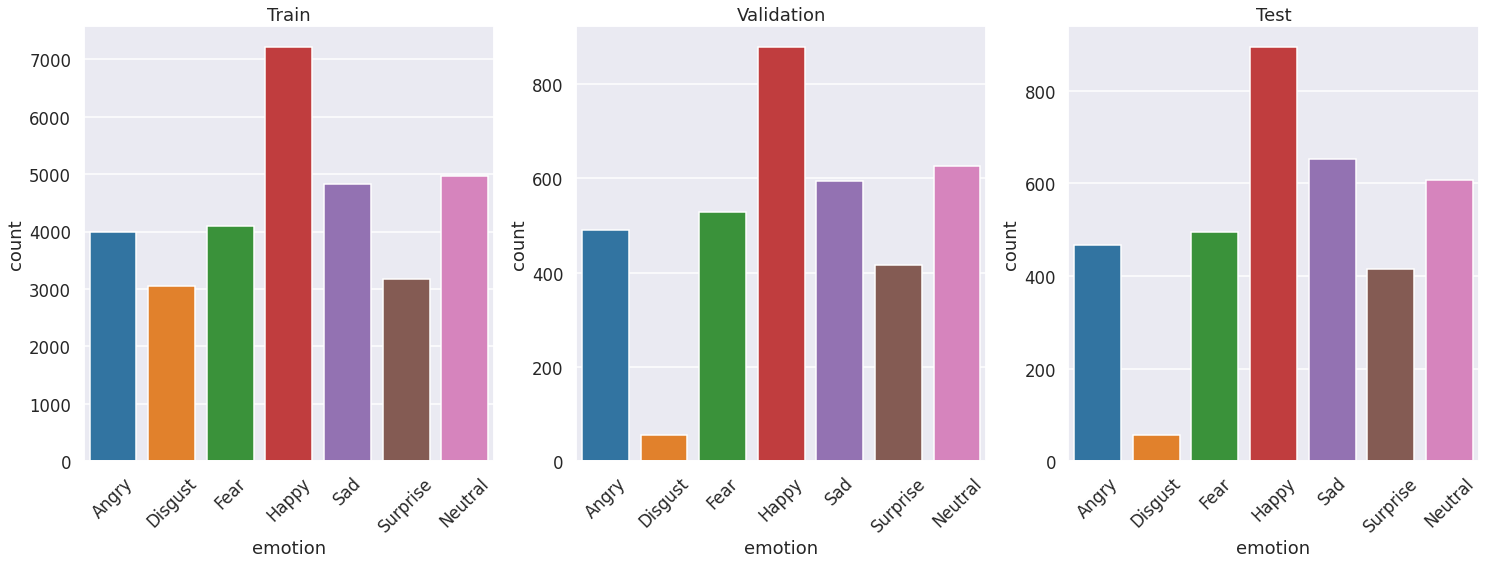

In [10]:
affichage_datas()

- On observe bien que la quantité de données de l'émotion 'disguqt' a bien augmenté pour le train set.

Implémentation d'une fonction qui va :
- transformer la colonne 'pixels' (chaîne de caractère) en liste d'entiers
- reshape et normaliser les images en niveaux de gris
- encoder les sorties (avec one-hot encoding)
- spliter le jeu de données

In [11]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

num_classes = 7
height, width = 48, 48
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

    
X_train, y_train = CRNO(data_train, "train") # training data
X_val, y_val = CRNO(data_val, "val") # validation data
X_test, y_test = CRNO(data_test, "test") # test data

train _X shape: (31325, 48, 48, 1),  train _Y shape: (31325, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


## Deep Learning

### Création du modèle CNN

In [12]:
def config_model():
  model = Sequential()

  # 1ère - couche de convolution
  model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # 2ème - couche de convolution
  model.add(Conv2D(128,(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))


  # 3ème - couche de convolution
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # 4ème - couche de convolution
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # applanissement
  model.add(Flatten())

  # couche entièrement connectée : 1ère couche
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.15))

  # couche entièrement connectée : 2ème couche
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.15))

  model.add(Dense(7, activation='softmax'))

  opt = Adam(lr=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

### Entraînement du modèle

In [14]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


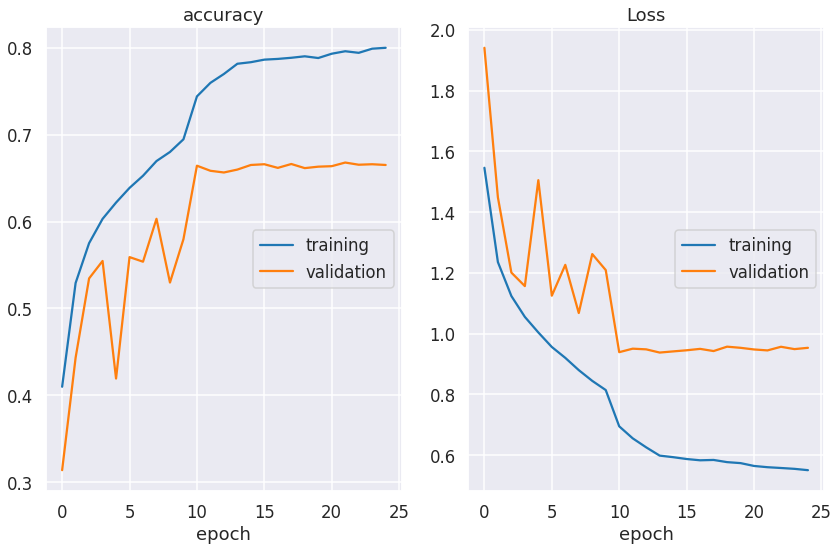

accuracy
	training         	 (min:    0.410, max:    0.800, cur:    0.800)
	validation       	 (min:    0.314, max:    0.668, cur:    0.665)
Loss
	training         	 (min:    0.551, max:    1.546, cur:    0.551)
	validation       	 (min:    0.938, max:    1.941, cur:    0.953)

Epoch 25: saving model to model_weights.h5
489/489 [==============================] - 18s 36ms/step - loss: 0.5509 - accuracy: 0.8000 - val_loss: 0.9535 - val_accuracy: 0.6652 - lr: 1.0000e-05


In [15]:
from livelossplot import PlotLossesKerasTF

def train_model(model):
  img_size = 48
  batch_size = 64


  datagen_train = ImageDataGenerator(horizontal_flip=True)
  train_generator = datagen_train.flow(X_train, y_train,
                                                      batch_size=batch_size,
                                                      shuffle=True)

  datagen_validation = ImageDataGenerator(horizontal_flip=True)
  validation_generator = datagen_validation.flow(X_val, y_val,
                                                      batch_size=batch_size)

  epochs = 25
  steps_per_epoch = train_generator.n//train_generator.batch_size
  validation_steps = validation_generator.n//validation_generator.batch_size

  # Reducing Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.00001, mode='auto')
  # Recuperation des poids qui ont le meilleurs score sur la validation
  checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                              save_weights_only=True, mode='max', verbose=1)
  
  

  # Training the Model
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      callbacks=[PlotLossesKerasTF(), reduce_lr, checkpoint]
  )
  return model

model = train_model(config_model())

### Accuracy globale

In [17]:
from sklearn.metrics import accuracy_score

test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 2s 6ms/step
CNN Model Accuracy on test set: 0.6620


L'accuracy globale est de 0,6620 ce qui est plutôt un bon résultat.

### Matrices de confusion

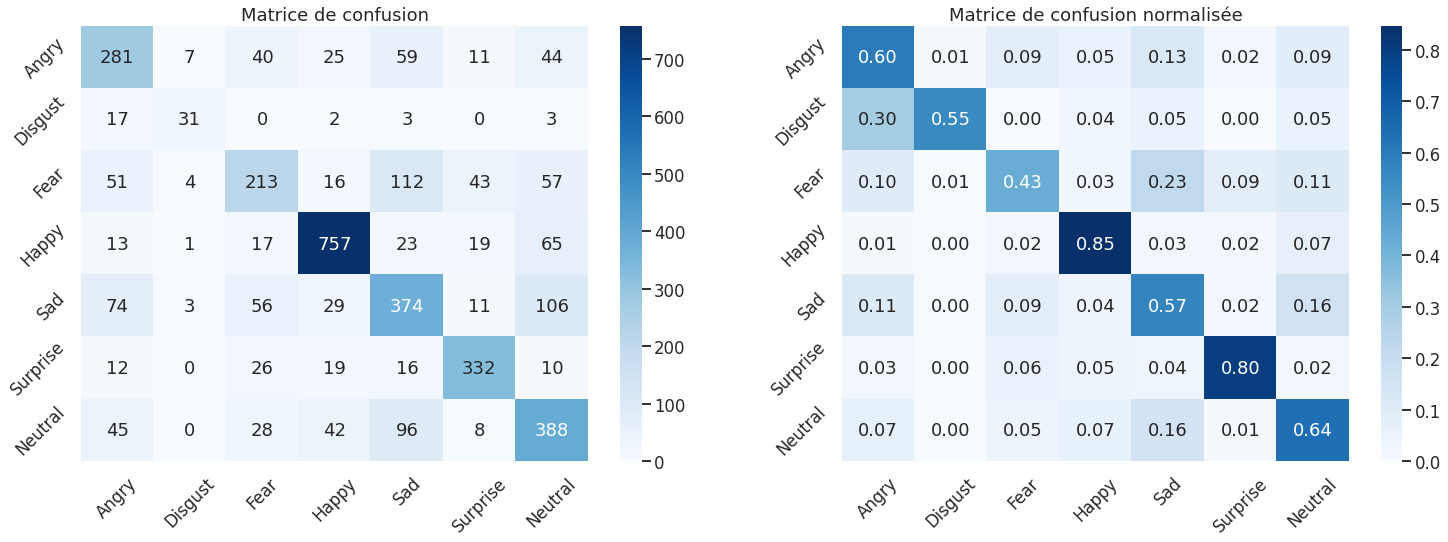

In [18]:
from sklearn.metrics import confusion_matrix
def matrice(test_true, test_pred):
  fig, ax = plt.subplots(1,2, figsize=(25,8))
  matrix = confusion_matrix(test_true, test_pred)
  sns.heatmap(matrix , annot=True,cmap='Blues',ax=ax[0], fmt="1")
  ax[0].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_yticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_title("Matrice de confusion")

  matrix = confusion_matrix(test_true, test_pred,normalize="true")
  sns.heatmap(matrix , annot=True,cmap='Blues',ax=ax[1],fmt=".2f")
  ax[1].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_yticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_title("Matrice de confusion normalisée")
  plt.show()
  return
matrice(test_true, test_pred)

On observe que le modèle fonctionne bien sur les émotions 'happy', 'surprise' et 'neutral'. La détection des émotions 'angry', 'disgust', 'fear' & 'sad' quant à elle fonctionne environ 1 fois sur 2.

### Sauvegarde du modèle

In [19]:
model.save('emotions.h5')